In [1]:
import pandas as pd
import sklearn as skr
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from typing import *
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1024)

labels = ['total_purchase_amt', 'total_redeem_amt']

In [14]:
# 分割数据集

def split_data_underline(data):
    trainset = data[(datetime.datetime(2014,4,1) <= data['date']) & (data['date'] < datetime.datetime(2014,8,1))]
    testset = data[(datetime.datetime(2014,8,1) <= data['date']) & (data['date'] < datetime.datetime(2014,9,1))]
    return trainset, testset

def split_data_online(data):
    trainset = data[(datetime.datetime(2014,4,1) <= data['date']) & (data['date'] < datetime.datetime(2014,9,1))]
    testset = data[(datetime.datetime(2014,9,1) <= data['date']) & (data['date'] < datetime.datetime(2014,10,1))]
    return trainset, testset

评价函数赛题中有给出，自行定义后可用于线下评估

In [3]:
# 定义评价函数

def AE(y: Iterable, yhat: Iterable)->Iterable:
    return np.abs(y - yhat) / np.abs(y)

def total_AE(purchasehat: Iterable, redeemhat: Iterable, purchase: Iterable, redeem: Iterable, h: int = 0.3)->Iterable:
    return sum(map(lambda x : np.exp(-x/h)*10, AE(purchase, purchasehat))) * 0.45 + sum(map(lambda x : np.exp(-x/h)*10, AE(redeem, redeemhat))) * 0.55

In [33]:
# 在不同的时间段对模型进行验证

def week_evalution_single(data, model, types):
    results = []
    a_month = relativedelta(months=1)
    for i in [datetime.datetime(2014, 8, 1), datetime.datetime(2014, 7, 25), datetime.datetime(2014, 7, 18), datetime.datetime(2014, 7, 11), 
          datetime.datetime(2014, 7, 4), datetime.datetime(2014, 6, 27), datetime.datetime(2014, 6,20)]:
        trainset = data[(i - 4 * a_month <= data['date']) & (data['date'] < i)]
        testset = data[(i <= data['date']) & (data['date'] < i + a_month)]
        if len(testset) == 0 or len(trainset) == 0:
            i = datetime.date(2014, 4, 20)
            trainset = data[(i - 4 * a_month <= data['date']) & (data['date'] < i)]
            testset = data[(i <= data['date']) & (data['date'] < datetime.datetime(2014, 9, 1))]
        feature = [x for x in trainset.columns if x not in ['total_purchase_amt','total_redeem_amt','date']]
        
        model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
        result_lr = model.predict(testset[feature])
        
        h = 0.3
        results.append(sum(AE(testset['total_' + types + '_amt'], result_lr).apply(lambda x : np.exp(-x/h))*10))
    return pd.DataFrame(results)

In [5]:
# 输出评级表格

def draw_eva_table(df):
    rest = df.copy()
    rest['interval'] = [datetime.datetime(2014, 8, 1), datetime.datetime(2014, 7, 25), datetime.datetime(2014, 7, 18), 
                        datetime.datetime(2014, 7, 11), datetime.datetime(2014, 7, 4), datetime.datetime(2014, 6, 27), 
                        datetime.datetime(2014, 6, 20)]
    return rest

In [42]:
# 对生成结果进行可视化

def visual(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->None:
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_purchase_lr, label='predicted_purchase')
    plt.plot(testset['date'], testset['total_purchase_amt'], label='real_purchase')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict purchase")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_purchase_lr - testset['total_purchase_amt'])

    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'], result_redeem_lr, label='predicted_redeem')
    plt.plot(testset['date'], testset['total_redeem_amt'], label='real_redeem')

    plt.legend(loc='best')
    plt.title("The distribution of real and predict redeem")
    plt.xlabel("Time")
    plt.ylabel("Amount")
    plt.show()
    fig = plt.figure(figsize=(10,4))
    sns.barplot(testset['date'].dt.day ,result_redeem_lr - testset['total_redeem_amt'])

In [17]:
# 定义提取线下最好效果特征的函数

def feature_extract(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], List[float]]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    score = -1
    for i in features:
        score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types))
        if score_update > score:
            score = score_update
            results.append(i)
    return results, score
    
def robust_feature_extract(data: pd.DataFrame, model: object, types: str):
    results = []
    score = -1
    for i in range(10):
        results_update, score_update = feature_extract(data, model, types)
        if score_update > score:
            score = score_update
            results = results_update
        print(results_update, score_update)
    return results

In [8]:
# 定义AIC,BIC评价指标

def AIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + 2 * (n_features + 1)
def BIC(L: Iterable, delta: float, n_features: int):
    return L * np.log10(delta) + (n_features + 1) * np.log10(L)

In [18]:
# 使用AIC指标融合模型

def feature_extract_AIC(data: pd.DataFrame, model: object, types: str)->Tuple[List[str], float]:
    features = [x for x in data.columns if x not in labels + ['date']]
    random.shuffle(features)
    results = []
    test_score = 1e9
    train_score = 0
    for i in features:
        test_score_update = np.mean(week_evalution_single(data[results + [i] + labels + ['date']], model, types)[0])
        if test_score_update < test_score:
            test_score = test_score_update
            results.append(i)
            
    trainset, testset = split_data_underline(data)
    feature = results
    model.fit(X=trainset[feature], y=trainset['total_' + types + '_amt'])
    train_result_lr = model.predict(trainset[feature])
    delta = mean_squared_error(train_result_lr, trainset['total_' + types + '_amt'])
    #delta = np.sum(AE(trainset['total_' + types + '_amt'], train_result_lr).apply(lambda x : np.exp(-x/0.1))*10)
    return results, AIC(len(trainset), delta, len(feature))

def multi_model(data: pd.DataFrame, model: object, types: str)->Tuple[List[List[str]], float]:
    features = []
    weights = []
    for i in range(100):
        results_update, score_update = feature_extract_AIC(data, model, types)
        features.append(results_update)
        weights.append(score_update)
    avg = np.mean(weights)
    weights = [x - avg for x in weights]
    weights = [np.power((-1 * x / 2), 10) for x in weights]
    summ = np.sum(weights)
    weights = [x / summ for x in weights]
    return features, weights

In [10]:
# 生成线上结果

def generate_online_result(df: pd.DataFrame, feature: Iterable, model = LinearRegression(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_online(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr

In [11]:
# 生成线下结果

def generate_under_result(df: pd.DataFrame, feature: Iterable, model = LinearRegression(), target:str = 'total_purchase_amt')->Iterable:
    trainset, testset = split_data_underline(df)
    model.fit(X=trainset[feature], y=trainset[target])
    result_purchase_lr = model.predict(testset[feature])
    return result_purchase_lr

In [12]:
# 生成线上提交的格式

def normalize_upload_file(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame)->pd.DataFrame:
    testset['total_purchase_amt'] = result_purchase_lr
    testset['total_redeem_amt'] = result_redeem_lr
    online_upload = testset[['date','total_purchase_amt','total_redeem_amt']]
    online_upload['date'] = online_upload['date'].astype(str)
    online_upload['date'] = online_upload['date'].str.replace('-','')
    return online_upload

In [53]:
# 生成线上提交的格式 v2

def normalize_upload_file_v2(result_purchase_lr, result_redeem_lr, testset_p, testset_r):
    testset_p['total_purchase_amt'] = result_purchase_lr
    testset_r['total_redeem_amt'] = result_redeem_lr
    
    online_upload = pd.merge(testset_p[['date','total_purchase_amt']],testset_r[['date','total_redeem_amt']],on='date')
    online_upload['date'] = online_upload['date'].astype(str)
    online_upload['date'] = online_upload['date'].str.replace('-','')
    return online_upload

In [13]:
# 线上结果可视化

def draw_result(result_purchase_lr: Iterable, result_redeem_lr: Iterable, testset: pd.DataFrame):
    fig = plt.figure(figsize=(10,4))
    plt.plot(testset['date'].dt.day, result_purchase_lr, label='online_purchase')
    plt.plot(testset['date'].dt.day, result_redeem_lr, label='online_redeem')

    plt.legend(loc='best')
    plt.title("The predict values")
    plt.xlabel("Time")
    plt.ylabel("Amount")

以下方程用于blending

In [19]:
# 重载DataFrame加法

def add_two_df(df1, df2, features = None, left_a = 0.45, right_a = 0.55):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] = (data[i] * left_a + df2[i] * right_a)
    return data

In [20]:
# 重载DataFrame乘法

def scale_df(df1, features = None, eta = 1):
    data = df1.copy()
    if not features:
        features = [x for x in data.columns if x != 'interval']
    for i in features:
        data[i] *= eta
    return data

## 建模
### 尝试只使用IS特征，也就是bool特征

In [43]:
data_p = pd.read_csv('Feature/purchase_bool_feature_0122.csv')
data_r = pd.read_csv('Feature/redeem_bool_feature_0122.csv')

data_p['report_date'] = pd.to_datetime(data_p['report_date'])
data_p.rename(columns={'report_date':'date'}, inplace=True)

data_r['report_date'] = pd.to_datetime(data_r['report_date'])
data_r.rename(columns={'report_date':'date'}, inplace=True)

In [44]:
trainset_p, testset_p = split_data_underline(data_p)
result_purchase_lr = generate_under_result(data_p, [x for x in data_p.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')


In [46]:
trainset_r, testset_r = split_data_underline(data_r)
result_redeem_lr = generate_under_result(data_r, [x for x in data_r.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                         target='total_redeem_amt')

**验证测试结果**

In [47]:
# 预测八月的测试结果
total_AE(result_purchase_lr, result_redeem_lr, testset_p['total_purchase_amt'], testset_r['total_redeem_amt'])

185.2223405314443

In [48]:
draw_eva_table(week_evalution_single(data_p, model=LinearRegression(), types = 'purchase'))

,0,interval
0,189.564547,2014-08-01
1,162.679905,2014-07-25
2,162.618294,2014-07-18
3,167.391973,2014-07-11
4,149.635957,2014-07-04
5,167.868427,2014-06-27
6,162.649194,2014-06-20


In [49]:
draw_eva_table(week_evalution_single(data_r, model=LinearRegression(), types = 'redeem'))

,0,interval
0,181.669626,2014-08-01
1,175.246058,2014-07-25
2,188.830575,2014-07-18
3,188.114603,2014-07-11
4,187.968378,2014-07-04
5,182.748321,2014-06-27
6,168.159730,2014-06-20


**预测与真实值以及残差可视化对比**

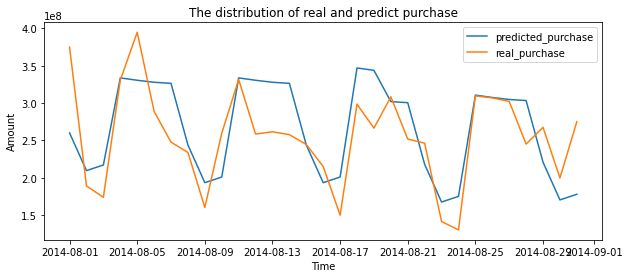

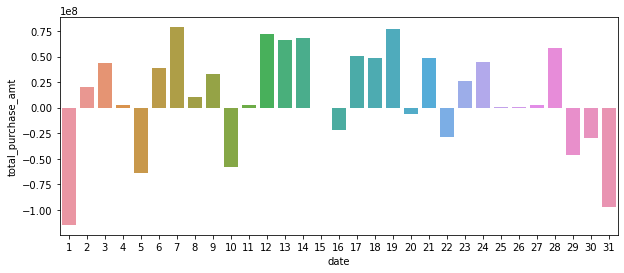

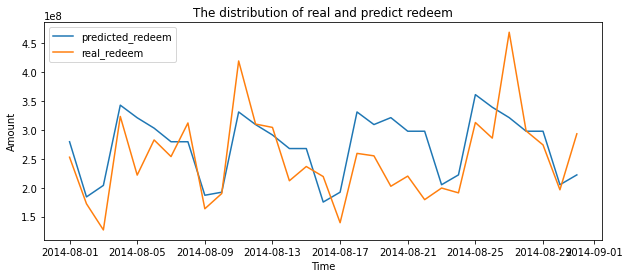

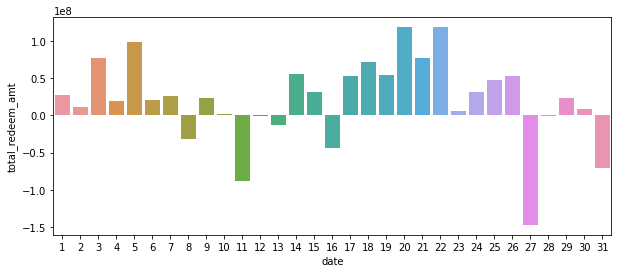

In [51]:
visual(result_purchase_lr, result_redeem_lr, testset_p)

**预测九月效果（LR）**

In [86]:
# 生成线上数据集
_, testset_p_o = split_data_online(data_p)
_, testset_r_o = split_data_online(data_r)

In [52]:
result_purchase_lr = generate_online_result(data_p, [x for x in trainset_p.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_r, [x for x in trainset_r.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          LinearRegression(),'total_redeem_amt')

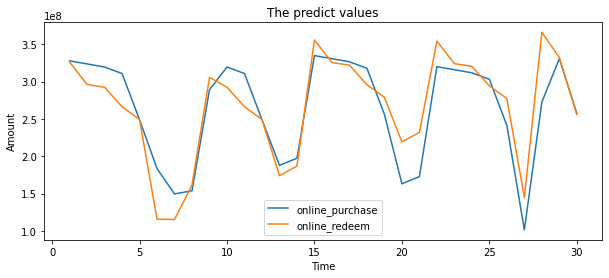

In [38]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

提交LR(only bool)测试结果

In [70]:
normalize_upload_file_v2(result_purchase_lr, result_redeem_lr, testset_p_o, testset_r_o).to_csv('Submission/202101222152_LR_only_bool.csv',index=False,header=None)

**多模型对比**  
用到LR，决策树回归，RF回归，GBDT，MLP，XGB

In [71]:
def multi_model_eva(data, types:str = 'purchase'):
    results = pd.DataFrame()
    for model in [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), MLPRegressor(solver='lbfgs'), xgb.XGBRegressor(objective='reg:squarederror')]:
        if results.empty:
            results = draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]})
        else:
            results = pd.merge(results, \
                               draw_eva_table(week_evalution_single(data, model, types)).rename(columns={0: repr(model).split('(')[0]}), on='interval')
    results = results[['interval'] + [x for x in results.columns if x != 'interval']]
    return results

In [72]:
add_two_df(multi_model_eva(data_p, 'purchase'), multi_model_eva(data_r, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,185.222341,171.765170,177.400547,172.244481,167.327941,169.103101
1,2014-07-25,169.591289,165.055557,165.398075,164.328273,161.174533,165.754222
2,2014-07-18,177.035049,178.824853,177.569894,175.099822,181.030270,180.079656
3,2014-07-11,178.789420,174.856240,175.753612,173.333059,175.330055,175.269297
4,2014-07-04,170.718789,171.743618,174.668542,172.543540,174.236947,172.040865
5,2014-06-27,176.052369,174.743679,173.073867,168.904710,173.058457,173.776406
6,2014-06-20,165.679989,167.442181,164.734507,162.724426,164.060892,166.229344


### 使用劣汰后的特征建模

In [156]:
data_purchase = pd.read_csv('Feature/purchase_feature_droped_0122.csv') # pruchase_feature_droped_dynamic_0123
data_purchase['report_date'] = pd.to_datetime(data_purchase['report_date'])
data_redeem = pd.read_csv('Feature/redeem_feature_droped_0123.csv') # redeem_feature_droped_dynamic_0123.csv')
data_redeem['report_date'] = pd.to_datetime(data_redeem['report_date'])
data_purchase.rename(columns={'report_date':'date'}, inplace=True)
data_redeem.rename(columns={'report_date':'date'}, inplace=True)

In [120]:
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_lr = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [121]:
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_lr = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [122]:
total_AE(result_purchase_lr, result_redeem_lr, testset_purchase['total_purchase_amt'], testset_redeem['total_redeem_amt'])

191.47664183366368

In [123]:
add_two_df(multi_model_eva(data_purchase, 'purchase'), multi_model_eva(data_redeem, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,191.476642,153.229282,172.718251,176.814152,179.320571,173.334295
1,2014-07-25,176.246616,156.976054,160.476662,164.885821,160.254578,169.861046
2,2014-07-18,181.088846,166.489282,176.819040,172.901360,159.633528,175.729198
3,2014-07-11,176.478791,182.715324,172.463508,166.501925,158.253057,173.103915
4,2014-07-04,171.346525,155.659369,156.658311,152.198892,150.057524,153.289347
5,2014-06-27,182.083183,129.753550,165.607403,150.725489,143.371385,155.229057
6,2014-06-20,167.835717,167.324662,171.068437,173.304554,136.408673,169.721650


**八月效果预测（LR）**

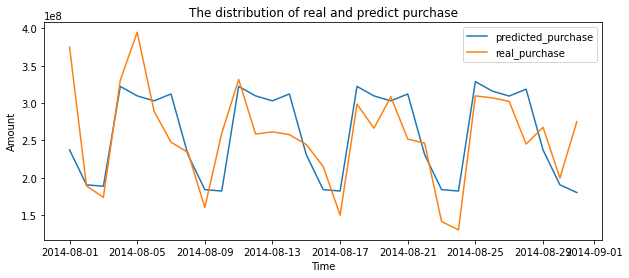

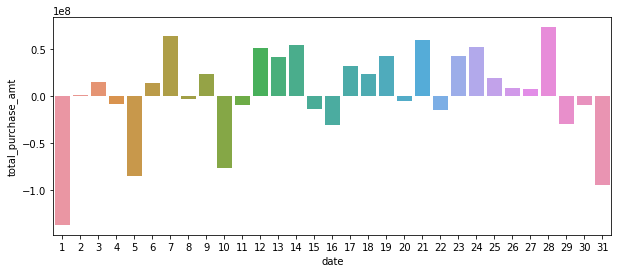

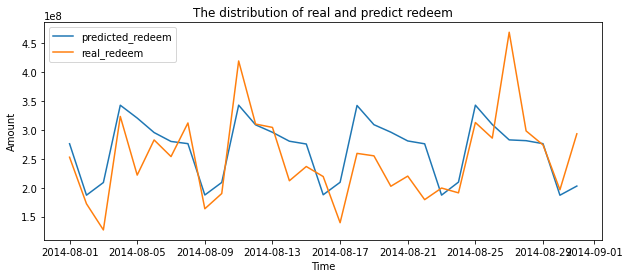

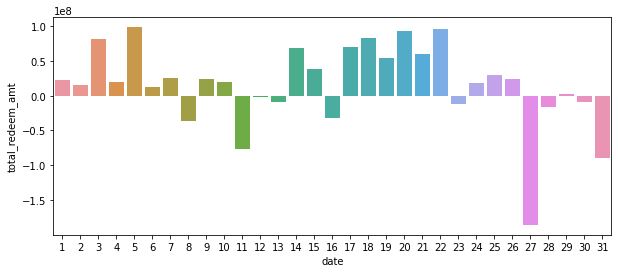

In [124]:
trainset, testset = split_data_underline(data)
visual(result_purchase_lr, result_redeem_lr, testset)

**线上效果（LR）**128

In [125]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

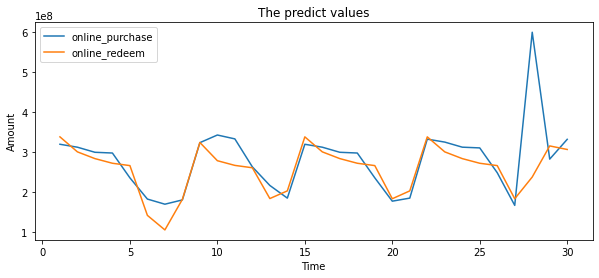

In [126]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [127]:
data_purchase.columns

Index(['is_weekend', 'dis_to_work', 'dis_from_work', 'purchase_weekdayrate',
       'dis_to_nowork%%%%dis_from_purchase_peak', 'redeem_dayrate',
       'weekday_onehot_5', 'weekday_onehot_6', 'dis_from_nowork',
       'is_firstday_of_work', 'is_holiday', 'weekday_onehot_1',
       'weekday_onehot_2', 'dis_from_middleofweek', 'dis_from_holiendday',
       'weekday_onehot_3', 'is_lastday_of_holiday', 'is_firstday_of_holiday',
       'weekday_onehot_4', 'is_third_week', 'dis_from_holiday',
       'total_purchase_amt', 'total_redeem_amt', 'date'],
      dtype='object')

In [128]:
data_redeem.columns

Index(['dis_from_redeem_peak', 'purchase_weekdayrate', 'redeem_dayrate',
       'was_worked_yesterday', 'redeem_weekday_min', 'is_firstday_of_work',
       'weekday_onehot_6', 'is_holiday', 'dis_from_nowork',
       'redeem_weekday_max', 'weekday_onehot_1', 'redeem_weekday_skew',
       'is_firstday_of_holiday', 'weekday_onehot_2', 'is_lastday_of_holiday',
       'dis_from_holiday', 'dis_from_redeem_peak%%%%dis_from_endofweek',
       'dis_from_holiendday', 'dis_from_redeem_peak%%%%dis_from_redeem_valley',
       'total_purchase_amt', 'total_redeem_amt', 'date'],
      dtype='object')

In [129]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('Submission/20210123_LR_droped_feature_1.csv',index=False,header=None)

**线上效果（lightgbm）**118

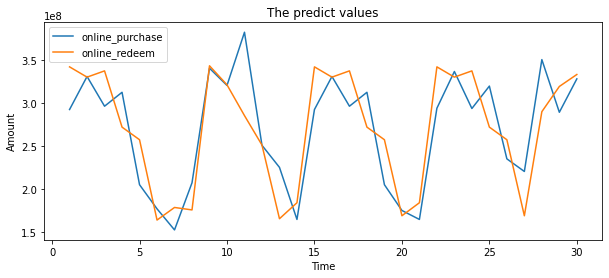

In [157]:
result_purchase_lgb = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                             lgb.LGBMRegressor(n_estimators=100),'total_purchase_amt')
result_redeem_lgb = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           lgb.LGBMRegressor(n_estimators=100),'total_redeem_amt')

trainset, testset = split_data_online(data)
draw_result(result_purchase_lgb, result_redeem_lgb, testset)

In [158]:
normalize_upload_file(result_purchase_lgb, result_redeem_lgb, testset).to_csv('Submission/20210123_LGB_droped_feature.csv',index=False,header=None)

**线上效果（xgboost）**114

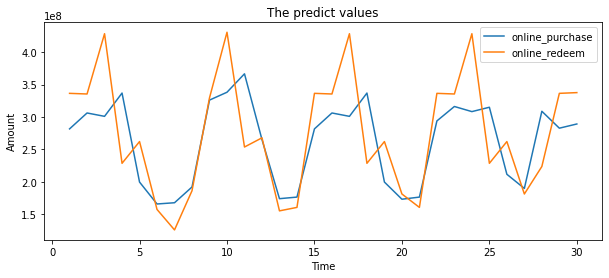

In [130]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            xgb.XGBRegressor(objective='reg:squarederror'),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          xgb.XGBRegressor(objective='reg:squarederror'),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [132]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('Submission/20210123_droped_XGB.csv',index=False,header=None)

**线上效果（RF）**119

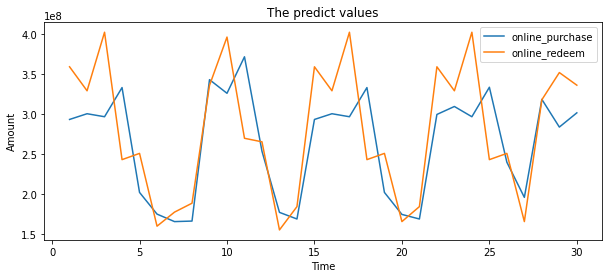

In [140]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            RandomForestRegressor(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          RandomForestRegressor(),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [141]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('Submission/20210123_droped_RF.csv',index=False,header=None)

**线上效果（GBDT）**123

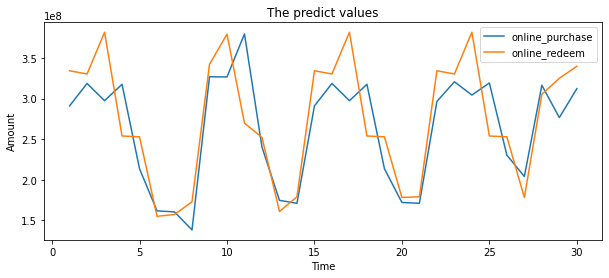

In [142]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            GradientBoostingRegressor(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          GradientBoostingRegressor(),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [143]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('Submission/20210123_droped_GBDT.csv',index=False,header=None)

### 使用最优20特征模型建模

In [159]:
data_purchase = pd.read_csv('Feature/purchase_best_feature_0122.csv')
data_purchase['report_date'] = pd.to_datetime(data_purchase['report_date'])
data_redeem = pd.read_csv('Feature/redeem_best_feature_0122.csv')
data_redeem['report_date'] = pd.to_datetime(data_redeem['report_date'])
data_purchase.rename(columns={'report_date':'date'}, inplace=True)
data_redeem.rename(columns={'report_date':'date'}, inplace=True)

In [146]:
trainset_purchase, testset_purchase = split_data_underline(data_purchase)
result_purchase_lr = generate_under_result(data_purchase, [x for x in data_purchase.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_purchase_amt')

In [147]:
trainset_redeem, testset_redeem = split_data_underline(data_redeem)
result_redeem_lr = generate_under_result(data_redeem, [x for x in data_redeem.columns
                                                           if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           target='total_redeem_amt')

In [148]:
total_AE(result_purchase_lr, result_redeem_lr, testset_purchase['total_purchase_amt'], testset_redeem['total_redeem_amt'])

188.58687868023148

In [149]:
add_two_df(multi_model_eva(data_purchase, 'purchase'), multi_model_eva(data_redeem, 'redeem'))

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,188.586879,166.955296,179.563263,175.814706,185.941290,165.843163
1,2014-07-25,173.632942,170.910431,171.748793,168.073847,176.250424,161.729487
2,2014-07-18,179.448320,181.814405,176.489025,172.742708,177.579433,174.125917
3,2014-07-11,177.768668,177.165869,176.381380,175.509462,170.961337,180.146459
4,2014-07-04,175.652531,169.007067,173.333191,171.822488,168.317936,163.993624
5,2014-06-27,178.978914,178.692333,186.300122,186.376034,178.293872,183.099886
6,2014-06-20,173.487763,167.137708,172.735792,171.330015,167.225770,167.086686


**线上效果（LR）**123

In [150]:
result_purchase_lr = generate_online_result(data_purchase, [x for x in data_purchase.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_purchase_amt')
result_redeem_lr = generate_online_result(data_redeem, [x for x in data_redeem.columns if x not in ['total_purchase_amt','total_redeem_amt','date']], LinearRegression(),'total_redeem_amt')

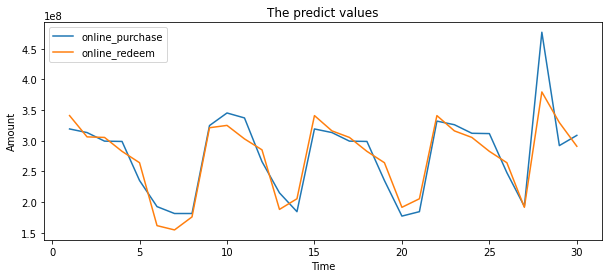

In [151]:
trainset, testset = split_data_online(data)
draw_result(result_purchase_lr, result_redeem_lr, testset)

In [152]:
normalize_upload_file(result_purchase_lr, result_redeem_lr, testset).to_csv('Submission/20210123_LR_best_feature.csv',index=False,header=None)

**线上效果（lightgbm）**

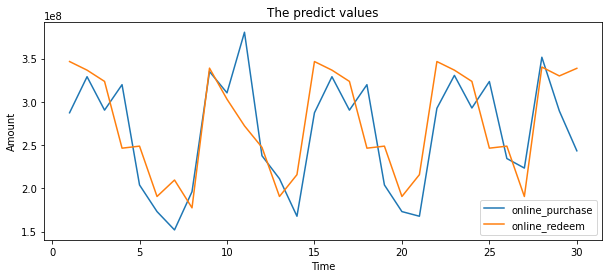

In [160]:
result_purchase_lgb = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                             lgb.LGBMRegressor(n_estimators=100),'total_purchase_amt')
result_redeem_lgb = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                           lgb.LGBMRegressor(n_estimators=100),'total_redeem_amt')

trainset, testset = split_data_online(data)
draw_result(result_purchase_lgb, result_redeem_lgb, testset)

In [161]:
normalize_upload_file(result_purchase_lgb, result_redeem_lgb, testset).to_csv('Submission/20210123_LGB_best_feature.csv',index=False,header=None)

**线上效果（GBDT）**114

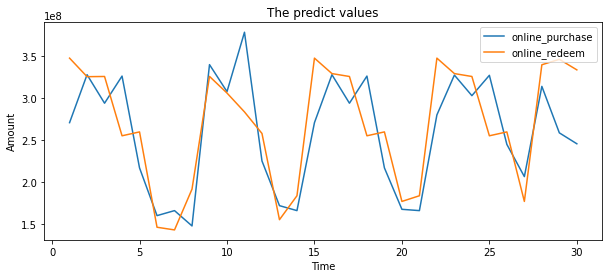

In [153]:
result_purchase_gbdt = generate_online_result(data_purchase, [x for x in data_purchase.columns 
                                                            if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                            GradientBoostingRegressor(),'total_purchase_amt')
result_redeem_gbdt = generate_online_result(data_redeem, [x for x in data_redeem.columns 
                                                        if x not in ['total_purchase_amt','total_redeem_amt','date']], 
                                          GradientBoostingRegressor(),'total_redeem_amt')
trainset, testset = split_data_online(data)
draw_result(result_purchase_gbdt, result_redeem_gbdt, testset)

In [154]:
normalize_upload_file(result_purchase_gbdt, result_redeem_gbdt, testset).to_csv('Submission/20210123_best_GBDT.csv',index=False,header=None)

### 利用AIC模型平均

In [133]:
purchase_features, purchase_weight = multi_model(data_purchase, model=LinearRegression(), types = 'purchase')

In [134]:
redeem_features, redeem_weight = multi_model(data_redeem, model=LinearRegression(), types = 'redeem')

In [135]:
def eva_for_aic(data_purchase, purchase_features, purchase_weight):
    results = pd.DataFrame()
    for index, feature in enumerate(purchase_features):
        if results.empty:
            results = scale_df(multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase'), 
                               eta = purchase_weight[index])
        else:
            results = add_two_df(results, multi_model_eva(data_purchase[['date'] + labels + feature], 'purchase')
                                 , left_a = 1,
                                 right_a = purchase_weight[index])
    return results

In [136]:
result = add_two_df(eva_for_aic(data_purchase, purchase_features, purchase_weight), 
                    eva_for_aic(data_redeem, redeem_features, redeem_weight))

In [137]:
result

,interval,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor
0,2014-08-01,198.659457,196.462684,195.190806,192.057197,192.584002,182.296578
1,2014-07-25,164.740013,168.358943,170.925833,169.931679,162.407578,167.429998
2,2014-07-18,158.426573,161.840812,162.147062,161.639658,161.604280,158.554530
3,2014-07-11,155.937139,166.699349,171.051707,167.453529,167.101168,169.383269
4,2014-07-04,152.262832,159.081524,160.837898,157.460217,154.025721,154.143691
5,2014-06-27,160.603661,161.623645,171.861324,162.640401,154.140705,157.822927
6,2014-06-20,160.386549,161.148425,159.947596,161.998564,128.292697,160.746960
